In [122]:
import shap
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
import xgboost
import shap
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X.iloc[:, 1:]

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape)

(9932, 18)


In [4]:
X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [5]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model_train

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:7.26934
[999]	test-cox-nloglik:6.55579


In [6]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 1000, evals = [(xgb_full, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-cox-nloglik:8.88081
[999]	test-cox-nloglik:8.16748


In [7]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8289463410825477

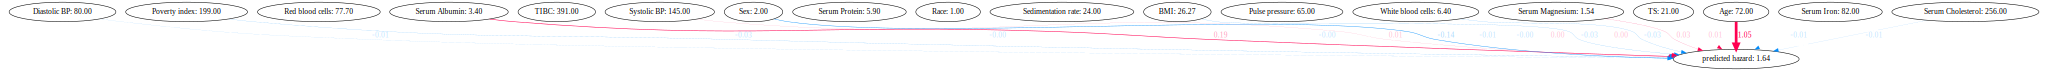

In [110]:
def build_graph(names, model, X, x):
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    nodes = [Node(name) for name in names]
    nodes.append(Node('predicted hazard', 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, [args[i]]) for i, name in enumerate(names)))))[0], 
                      nodes, is_target_node=True))
    
    def idx_f(idx, f):
        def f_():
            return f(idx)
        return f_
    
    graph = Graph(nodes,
                  dict((name, idx_f(i, lambda i: np.array(X)[np.random.choice(len(X))][i])) 
                       for i, name in enumerate(names)),
                  dict((name, idx_f(i, lambda i: np.array(x)[i])) 
                       for i, name in enumerate(names)))

    return graph

sample_ind = 60 # 30
graph = build_graph(list(X.columns), model, X, X.iloc[sample_ind])
verbose = False #True
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

G = cf.credit2dot(format_str='{:.2f}')
viz_graph(G)
# save_graph(G, 'graph.png')

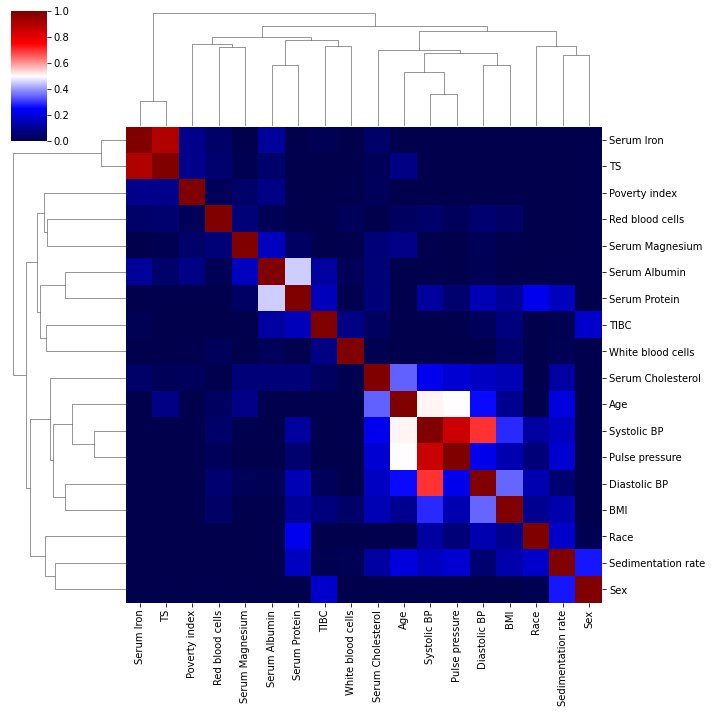

In [55]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

In [9]:
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1], label=y[sample_ind:sample_ind+1])))
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age                    41.000000
Diastolic BP           82.000000
Poverty index         256.000000
Race                    1.000000
Red blood cells        77.700000
Sedimentation rate      5.000000
Serum Albumin           4.000000
Serum Cholesterol     206.000000
Serum Iron             79.000000
Serum Magnesium         1.710000
Serum Protein           7.100000
Sex                     2.000000
Systolic BP           128.000000
TIBC                  351.000000
TS                     22.500000
White blood cells       8.300000
BMI                    33.901116
Pulse pressure         46.000000
Name: 30, dtype: float64
target: [0.15178627]
target: [0.15178627]


In [49]:
explainer = shap.KernelExplainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), shap.sample(X, 300))
shap_values = explainer.shap_values(X.iloc[sample_ind:sample_ind+1])

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


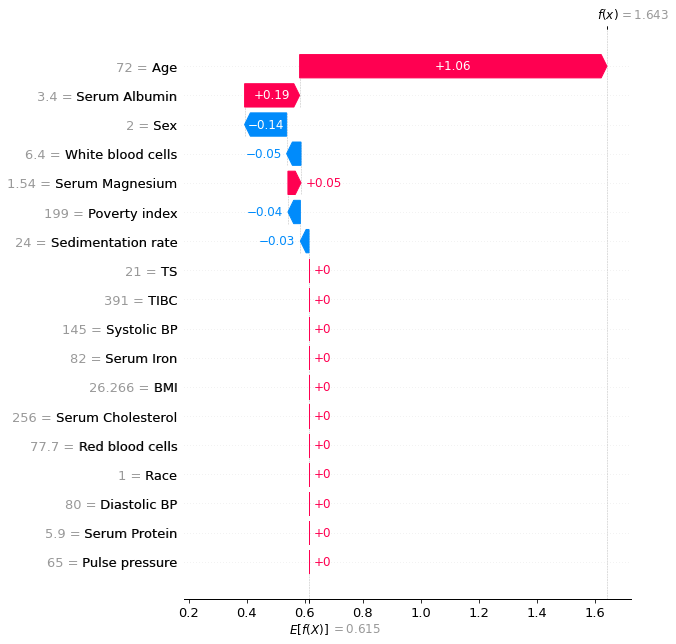

In [50]:
shap.waterfall_plot(explainer.expected_value, shap_values[0], X.iloc[sample_ind], max_display=20)

In [73]:
explainer = shap.SamplingExplainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), X, nsamples=10000) # nsamples=1000 * number of varying parameters
shap_values = explainer.shap_values(X.iloc[sample_ind:sample_ind+1])

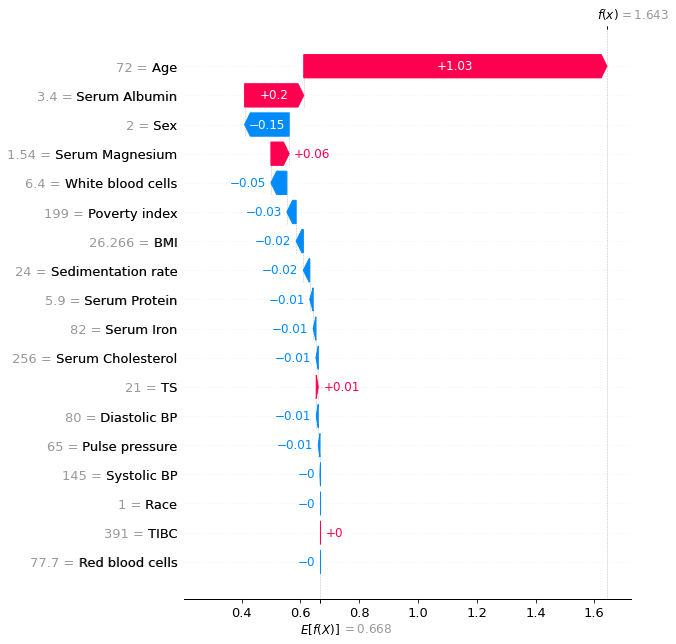

In [74]:
shap.waterfall_plot(explainer.expected_value, shap_values[0], X.iloc[sample_ind], max_display=20)

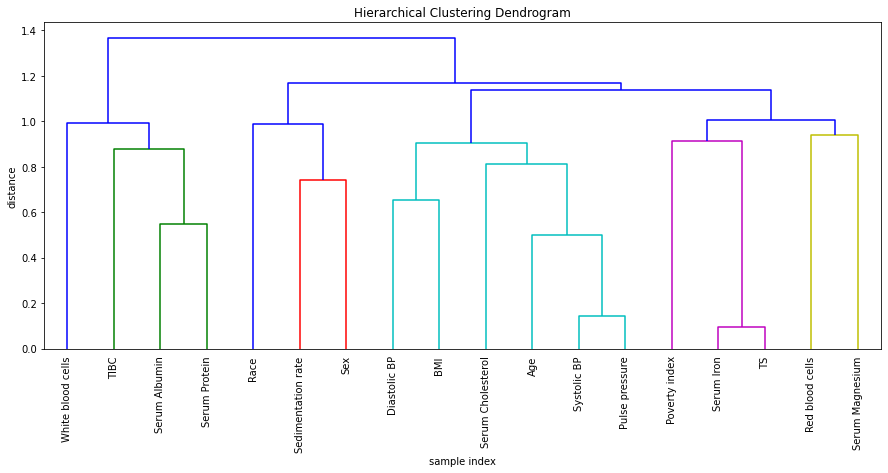

In [62]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

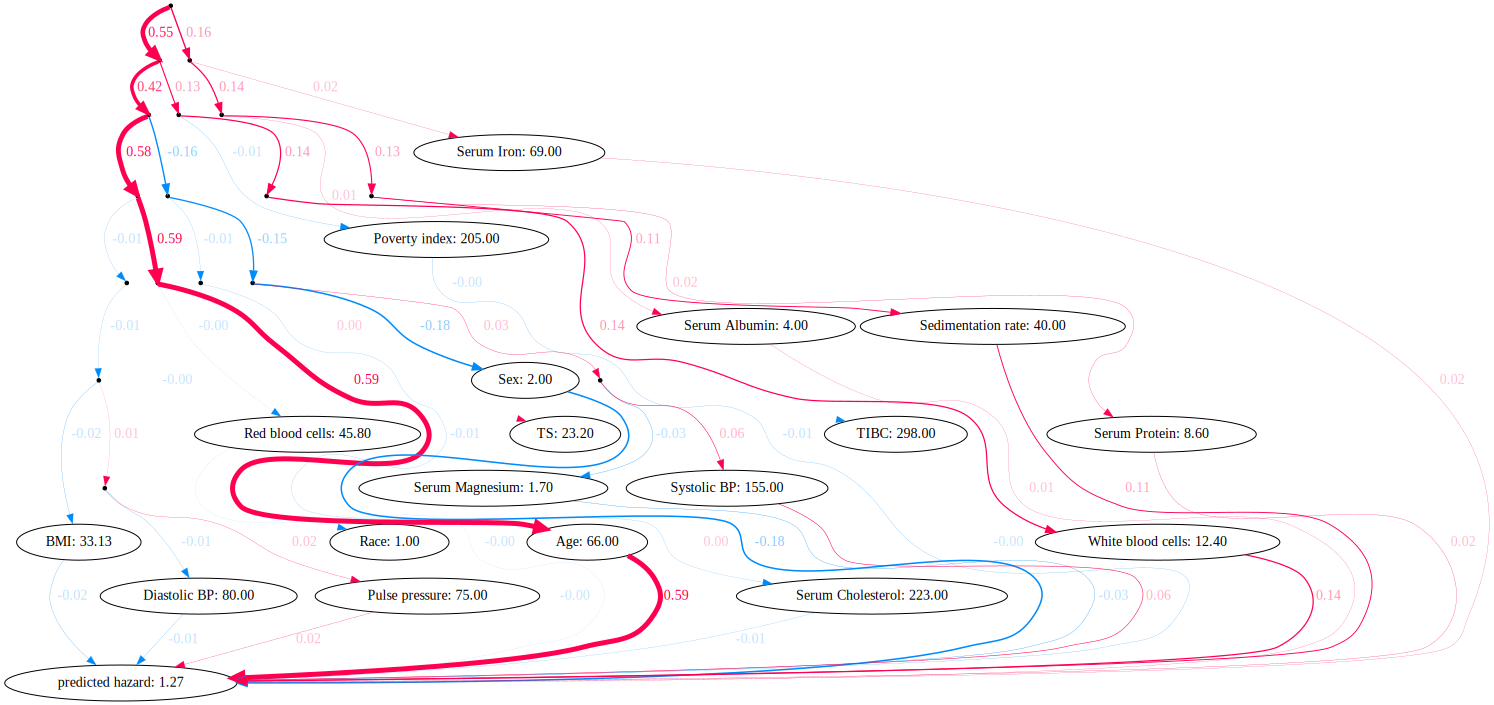

In [124]:
sample_ind = 600 # 60 30 # interesting ones [300, 600]
graph = build_graph(list(X.columns), model, X, X.iloc[sample_ind])
hgraph = hcluster_graph(graph, cluster_matrix)
verbose = False #True
cf = CreditFlow(hgraph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

G = cf.credit2dot(format_str='{:.2f}')
viz_graph(G)
# save_graph(G, 'graph.png')

In [68]:
explainer = shap.PartitionExplainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), X, cluster_matrix)
shap_values = explainer.shap_values(X.iloc[sample_ind:sample_ind+1])

PartitionExplainer is still in an alpha state, so use with caution...


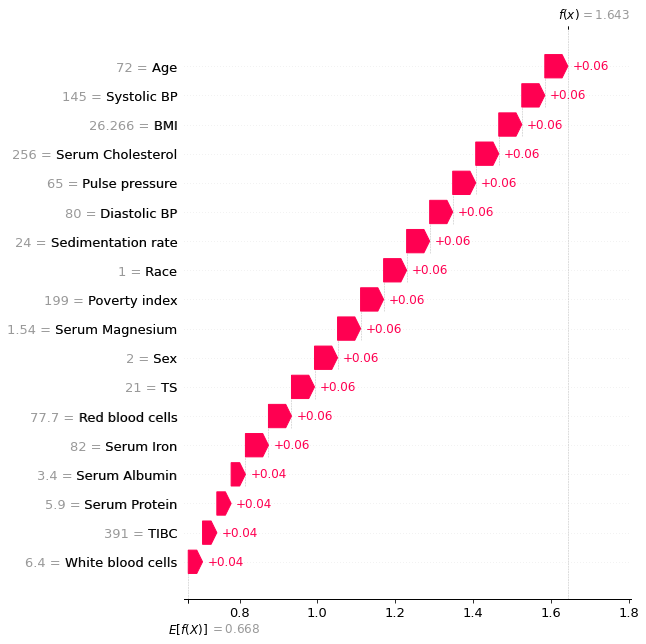

In [69]:
shap.waterfall_plot(explainer.expected_value, shap_values[0], X.iloc[sample_ind], max_display=20)

# Ask Scott why the result of f(x) is different in tree compared to kernel?

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.iloc[sample_ind:sample_ind+1])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


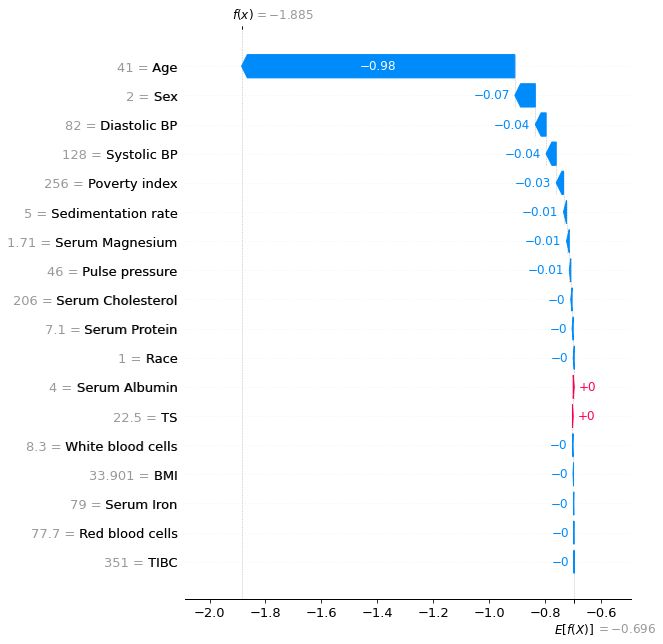

In [13]:
shap.waterfall_plot(explainer.expected_value, shap_values[0], X.iloc[sample_ind], max_display=20)

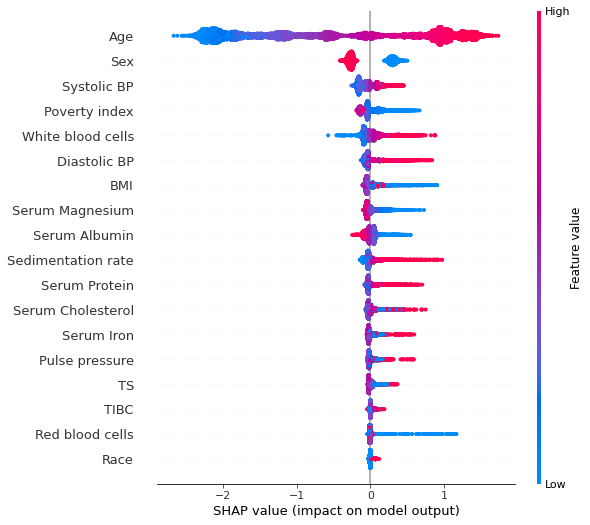

In [184]:
shap.summary_plot(shap_values, X)